# Tetr.io Rank Predictor 

Goal: To predict Tetr.io rank based on a player's TETRA LEAGUE statistics such as **APM (Attack-per-Minute)**, **PPS (Pieces-per-Second)**, and **VS Score**.

### Note: 
The comments here derive from the data taken on Februrary 17, 2021. Since this program collects the current live data, there may be variations in the results. 

In [167]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import math

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
%matplotlib inline

Get Tetr.io Tetra League data from API

In [4]:
full_data = requests.get("https://ch.tetr.io/api/users/lists/league/all")

Turn data from JSON file into a Pandas DataFrame. We only include the user data and disregard the rest.

In [5]:
full_dict = json.loads(full_data.text)

all_players = []

working_dict = full_dict['data']['users']

for p in range(len(working_dict)): # For every player

  player = {}

  for a in working_dict[p]: # For every attribute of player

    if a != "league":

      player[a] = working_dict[p][a] # Add attributes that are not part of league

  for a in working_dict[p]["league"]:

    player[a] = working_dict[p]["league"][a]

  all_players.append(player)

df = pd.DataFrame(all_players, index=[i for i in range(len(all_players))])

# Optionally save to csv
# df.to_csv('TetrioAll.csv') 


In [6]:
df

,_id,username,role,xp,supporter,verified,country,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,decaying
0,5e844b0868270e617d52c990,czsmall0402,user,13479336.5,False,True,None,364,339,24998.617107,4082.144266,88.978358,x,124.36,2.07,258.40,False
1,615fb20fe17beeef45104302,blaarg,user,2844617.0,True,True,US,943,801,24998.503289,4053.465814,71.460151,x,196.25,3.77,387.58,False
2,5f5dbcc4454e942b4fdfc5fa,vincehd,user,7784214.0,True,True,PH,631,463,24997.945328,3966.510346,66.481173,x,162.54,3.25,344.29,False
3,5e912413de03bc77bc821f65,rideris,user,2568845.0,True,True,JP,395,307,24997.070863,3882.027101,77.741885,x,151.81,3.27,350.42,False
4,5eb11da1e47b643b5d12e5f1,kazu,user,4254498.0,True,False,JP,1399,1074,24996.598631,3837.309911,71.349283,x,154.46,3.15,313.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44106,61bbad11e9c8d503799e7ac6,nbventi,user,169545.0,NaN,False,CA,118,22,177.746801,204.427958,78.666747,d,4.31,2.01,7.56,True
44107,6181febac2c05fb30f5e89a4,grrrei,user,184151.0,NaN,False,PH,75,14,167.216062,177.751394,90.735995,d,3.37,0.53,7.03,False
44108,624dd13b2b740ca380b96776,not_trinity,user,106786.0,NaN,False,US,81,6,155.926077,169.801122,67.766850,d,2.20,0.55,4.29,False
44109,5f2257a36c85e811417b3c0a,foul_beast,user,5035760.0,NaN,False,AU,1602,710,149.242189,159.698857,64.029029,d,1.42,0.44,3.15,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44111 entries, 0 to 44110
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          44111 non-null  object 
 1   username     44111 non-null  object 
 2   role         44111 non-null  object 
 3   xp           44111 non-null  float64
 4   supporter    2694 non-null   object 
 5   verified     44111 non-null  bool   
 6   country      43621 non-null  object 
 7   gamesplayed  44111 non-null  int64  
 8   gameswon     44111 non-null  int64  
 9   rating       44111 non-null  float64
 10  glicko       44111 non-null  float64
 11  rd           44111 non-null  float64
 12  rank         44111 non-null  object 
 13  apm          44111 non-null  float64
 14  pps          44111 non-null  float64
 15  vs           44111 non-null  float64
 16  decaying     44111 non-null  bool   
dtypes: bool(2), float64(7), int64(2), object(6)
memory usage: 5.5+ MB


### ALL features:

_id (string) — The user's internal ID.  
username (string) — The user's username.  
role (string) — The user's role (one of "anon", "user", "bot", "mod", "admin").  
xp (float) — The user's XP in points.  
country (string?) — The user's ISO 3166-1 country code, or null if hidden/unknown. Some vanity flags exist.  
supporter (bool) — Whether this user is currently supporting TETR.IO <3  
verified (bool) — Whether this user is a verified account.  
league (object) — This user's current TETRA LEAGUE standing:  
gamesplayed (int) — The amount of TETRA LEAGUE games played by this user.  
gameswon (int) — The amount of TETRA LEAGUE games won by this user.  
rating (float) — This user's TR (Tetra Rating), or -1 if less than 10 games were played.  
rank (string) — This user's letter rank. Z is unranked.  
glicko? (float) — This user's Glicko-2 rating.  
rd? (float) — This user's Glicko-2 Rating Deviation. If over 100, this user is unranked.  
apm? (float) — This user's average APM (attack per minute) over the last 10 games.  
pps? (float) — This user's average PPS (pieces per second) over the last 10 games.  
vs? (float) — This user's average VS (versus score) over the last 10 games.  
decaying (bool) — Whether this user's RD is rising (has not played in the last week).  

### USEFUL FEATURES:
xp (float) — The user's XP in points. May have positive correlation to rank as players who play more have more xp.  
role (string) — The user's role (one of "anon", "user", "bot", "mod", "admin").  
gamesplayed (int) — The amount of TETRA LEAGUE games played by this user. Similar reason to xp.  
gameswon (int) — The amount of TETRA LEAGUE games won by this user.  
rating (float) — This user's TR (Tetra Rating), or -1 if less than 10 games were played.  
rank (string) — This user's letter rank. Z is unranked.  
glicko? (float) — This user's Glicko-2 rating.  
rd? (float) — This user's Glicko-2 Rating Deviation. If over 100, this user is unranked.  
apm? (float) — This user's average APM (attack per minute) over the last 10 games.  
pps? (float) — This user's average PPS (pieces per second) over the last 10 games.  
vs? (float) — This user's average VS (versus score) over the last 10 games.  



## Data Cleaning:
3 Options for prediction:  
1.  Regression on TR rating (numerical value of rank)  
2.  Regression on Glicko  
3.  Classification on letter Rank  

In [ ]:
ranks = {'d': 1, 'd+': 2, 'c-': 3, 'c': 4, 'c+': 5, 'b-': 6, 'b': 7, 'b+': 8, 'a-': 9, 'a':10, 'a+': 11, 's-': 12, 's': 13, 's+': 14, 'ss': 15, 'u': 16, 'x': 17}

In [60]:
def process_data(df, rank_dict=None):
    df = df[(df['role'] != "anon") & (df['role'] != "bot") & (df['rank'] != 'z')]
    df = df[(df['rd'] <= 100) & (df['rating'] != -1)]
    main_feat = [
        "xp",
        "gamesplayed",
        "gameswon",
        "rating",
        "glicko",
        "rd",
        "rank",
        "apm",
        "pps",
        "vs"
    ]
    main_df = df.loc[:, main_feat]
    main_df['winratio'] = main_df['gameswon'] / main_df['gamesplayed']
    if(rank_dict != None):
        main_df['rank_num'] = main_df['rank'].map(rank_dict)
    df_shuffled = shuffle(main_df, random_state=1)
    w_df = df_shuffled.reset_index(drop=True)
    return w_df

In [8]:
# Drop all roles of "anon" and "bot" which theoretically should not be any due to how TETRA LEAGUE requires valid players.
df = df[df['role'] != "anon"]
df = df[df['role'] != "bot"] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44111 entries, 0 to 44110
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          44111 non-null  object 
 1   username     44111 non-null  object 
 2   role         44111 non-null  object 
 3   xp           44111 non-null  float64
 4   supporter    2694 non-null   object 
 5   verified     44111 non-null  bool   
 6   country      43621 non-null  object 
 7   gamesplayed  44111 non-null  int64  
 8   gameswon     44111 non-null  int64  
 9   rating       44111 non-null  float64
 10  glicko       44111 non-null  float64
 11  rd           44111 non-null  float64
 12  rank         44111 non-null  object 
 13  apm          44111 non-null  float64
 14  pps          44111 non-null  float64
 15  vs           44111 non-null  float64
 16  decaying     44111 non-null  bool   
dtypes: bool(2), float64(7), int64(2), object(6)
memory usage: 5.5+ MB


Drop unranked users (Z rank, rd > 100, and those with -1 rating)

In [9]:
df['rank'].value_counts()

a     3567
b-    3550
b     3521
b+    3516
a-    3504
a+    3486
s-    3127
c+    2667
s     2657
ss    2643
c     2640
s+    2639
c-    2175
u     1754
d+    1117
d     1092
x      455
z        1
Name: rank, dtype: int64

In [10]:
df = df[df['rank'] != 'z']
df = df[df['rd'] <= 100]
df = df[df['rating'] != -1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44110 entries, 0 to 44110
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          44110 non-null  object 
 1   username     44110 non-null  object 
 2   role         44110 non-null  object 
 3   xp           44110 non-null  float64
 4   supporter    2694 non-null   object 
 5   verified     44110 non-null  bool   
 6   country      43620 non-null  object 
 7   gamesplayed  44110 non-null  int64  
 8   gameswon     44110 non-null  int64  
 9   rating       44110 non-null  float64
 10  glicko       44110 non-null  float64
 11  rd           44110 non-null  float64
 12  rank         44110 non-null  object 
 13  apm          44110 non-null  float64
 14  pps          44110 non-null  float64
 15  vs           44110 non-null  float64
 16  decaying     44110 non-null  bool   
dtypes: bool(2), float64(7), int64(2), object(6)
memory usage: 5.5+ MB


Remove all non-useful features

In [11]:
main_feat = [
    "xp",
    "gamesplayed",
    "gameswon",
    "rating",
    "glicko",
    "rd",
    "rank",
    "apm",
    "pps",
    "vs"
]
main_df = df.loc[:, main_feat]
main_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs
0,13479336.5,364,339,24998.617107,4082.144266,88.978358,x,124.36,2.07,258.40
1,2844617.0,943,801,24998.503289,4053.465814,71.460151,x,196.25,3.77,387.58
2,7784214.0,631,463,24997.945328,3966.510346,66.481173,x,162.54,3.25,344.29
3,2568845.0,395,307,24997.070863,3882.027101,77.741885,x,151.81,3.27,350.42
4,4254498.0,1399,1074,24996.598631,3837.309911,71.349283,x,154.46,3.15,313.19
...,...,...,...,...,...,...,...,...,...,...
44106,169545.0,118,22,177.746801,204.427958,78.666747,d,4.31,2.01,7.56
44107,184151.0,75,14,167.216062,177.751394,90.735995,d,3.37,0.53,7.03
44108,106786.0,81,6,155.926077,169.801122,67.766850,d,2.20,0.55,4.29
44109,5035760.0,1602,710,149.242189,159.698857,64.029029,d,1.42,0.44,3.15


In [12]:
# Create win-ratio feature
main_df['winratio'] = main_df['gameswon'] / main_df['gamesplayed']
main_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio
0,13479336.5,364,339,24998.617107,4082.144266,88.978358,x,124.36,2.07,258.40,0.931319
1,2844617.0,943,801,24998.503289,4053.465814,71.460151,x,196.25,3.77,387.58,0.849417
2,7784214.0,631,463,24997.945328,3966.510346,66.481173,x,162.54,3.25,344.29,0.733756
3,2568845.0,395,307,24997.070863,3882.027101,77.741885,x,151.81,3.27,350.42,0.777215
4,4254498.0,1399,1074,24996.598631,3837.309911,71.349283,x,154.46,3.15,313.19,0.767691
...,...,...,...,...,...,...,...,...,...,...,...
44106,169545.0,118,22,177.746801,204.427958,78.666747,d,4.31,2.01,7.56,0.186441
44107,184151.0,75,14,167.216062,177.751394,90.735995,d,3.37,0.53,7.03,0.186667
44108,106786.0,81,6,155.926077,169.801122,67.766850,d,2.20,0.55,4.29,0.074074
44109,5035760.0,1602,710,149.242189,159.698857,64.029029,d,1.42,0.44,3.15,0.443196


Map each rank into a numerical value. (This isn't the best solution as later on it shows that there are too many categories to predict and too few data)

In [13]:
ranks = {'d': 1, 'd+': 2, 'c-': 3, 'c': 4, 'c+': 5, 'b-': 6, 'b': 7, 'b+': 8, 'a-': 9, 'a':10, 'a+': 11, 's-': 12, 's': 13, 's+': 14, 'ss': 15, 'u': 16, 'x': 17}
main_df['rank_num'] = main_df['rank'].map(ranks)
main_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio,rank_num
0,13479336.5,364,339,24998.617107,4082.144266,88.978358,x,124.36,2.07,258.40,0.931319,17
1,2844617.0,943,801,24998.503289,4053.465814,71.460151,x,196.25,3.77,387.58,0.849417,17
2,7784214.0,631,463,24997.945328,3966.510346,66.481173,x,162.54,3.25,344.29,0.733756,17
3,2568845.0,395,307,24997.070863,3882.027101,77.741885,x,151.81,3.27,350.42,0.777215,17
4,4254498.0,1399,1074,24996.598631,3837.309911,71.349283,x,154.46,3.15,313.19,0.767691,17
...,...,...,...,...,...,...,...,...,...,...,...,...
44106,169545.0,118,22,177.746801,204.427958,78.666747,d,4.31,2.01,7.56,0.186441,1
44107,184151.0,75,14,167.216062,177.751394,90.735995,d,3.37,0.53,7.03,0.186667,1
44108,106786.0,81,6,155.926077,169.801122,67.766850,d,2.20,0.55,4.29,0.074074,1
44109,5035760.0,1602,710,149.242189,159.698857,64.029029,d,1.42,0.44,3.15,0.443196,1


The data is currently organized in descending order by rank. As this will cause problems when I later go to split the data into training and test sets, I shuffle the data around.

In [14]:
from sklearn.utils import shuffle
df_shuffled = shuffle(main_df, random_state=1)
w_df = df_shuffled.reset_index(drop=True)
w_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio,rank_num
0,391249.0,227,104,4015.128012,1065.996198,69.323796,c+,11.05,0.82,22.00,0.458150,5
1,1428871.0,674,343,9840.002815,1386.593515,98.724149,b+,14.49,0.92,31.46,0.508902,8
2,259914.0,98,56,6331.781342,1216.882010,61.498757,b,21.04,0.80,38.79,0.571429,7
3,547439.0,77,49,9171.385908,1356.913698,90.179085,b+,25.38,0.90,47.93,0.636364,8
4,262688.0,134,65,1428.925498,764.088339,90.512336,c-,7.34,0.64,14.50,0.485075,3
...,...,...,...,...,...,...,...,...,...,...,...,...
44105,132009.0,39,9,458.952819,455.446185,87.159710,d,5.99,0.56,10.93,0.230769,1
44106,332077.5,153,83,5304.005526,1156.013116,66.211362,b-,11.82,0.82,23.60,0.542484,6
44107,1830967.0,532,282,21129.588330,1944.330700,60.642321,s+,46.03,1.44,93.12,0.530075,14
44108,316694.0,154,80,17017.556216,1698.824552,76.877914,s-,19.64,1.13,43.84,0.519481,12


<AxesSubplot:>

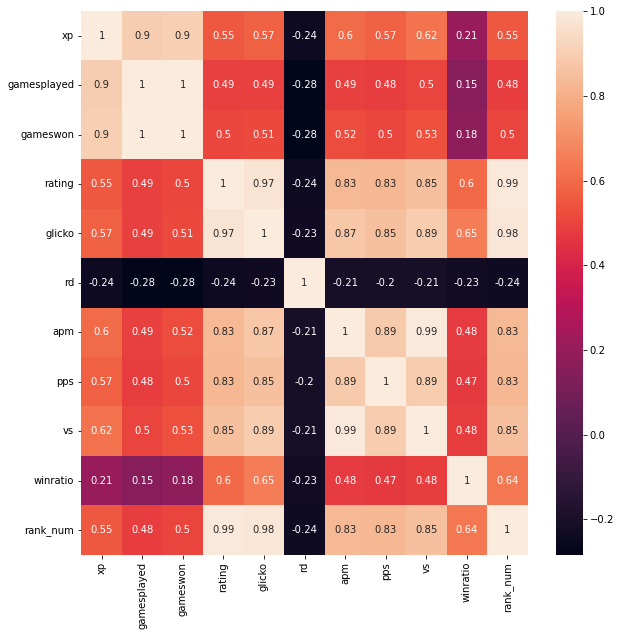

In [15]:
corr_mat = w_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, annot=True)


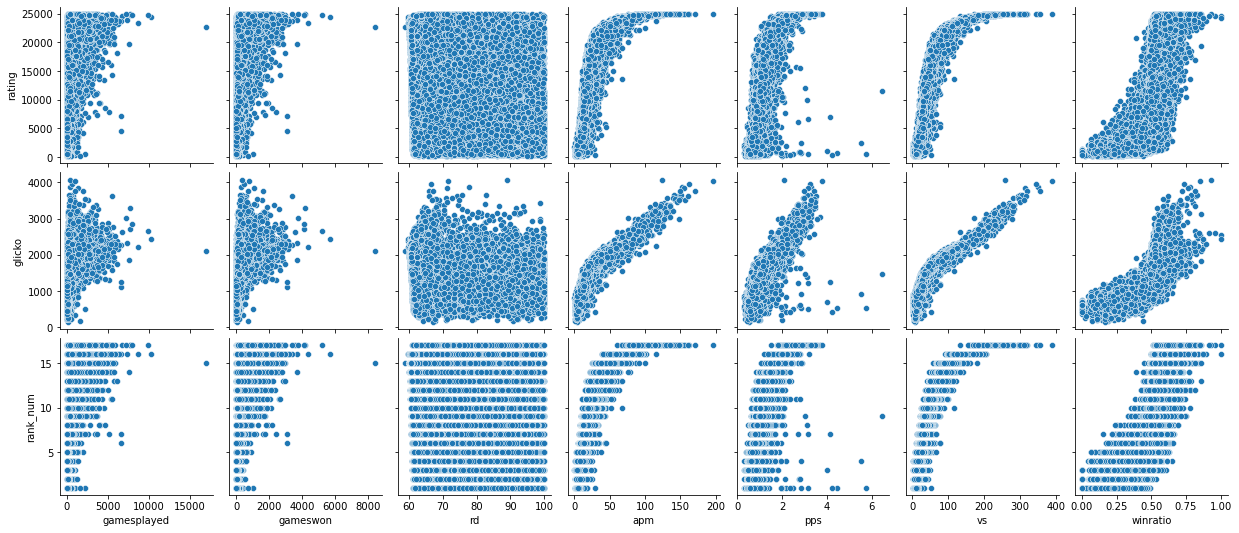

In [16]:
# fig, ax = plt.subplots(figsize=(20,20))
sns.pairplot(w_df,
            x_vars=['gamesplayed', 'gameswon', 'rd', 'apm', 'pps', 'vs', 'winratio'],
            y_vars=['rating', 'glicko', 'rank_num']
)

**Notes**:
*  gamesplayed and gameswon are unexpectedly bell curved with respect to glicko
*  rd does not have much correlation to any interpretation of rank
*  apm, pps, vs are more linear with respect to glicko in comparison to logrithmic shape of rating and rank_num
*  winratio seems to be a better feature for prediction tasks compared to the raw features of gamesplayed and gameswon

# Classification: Letter Rank

---



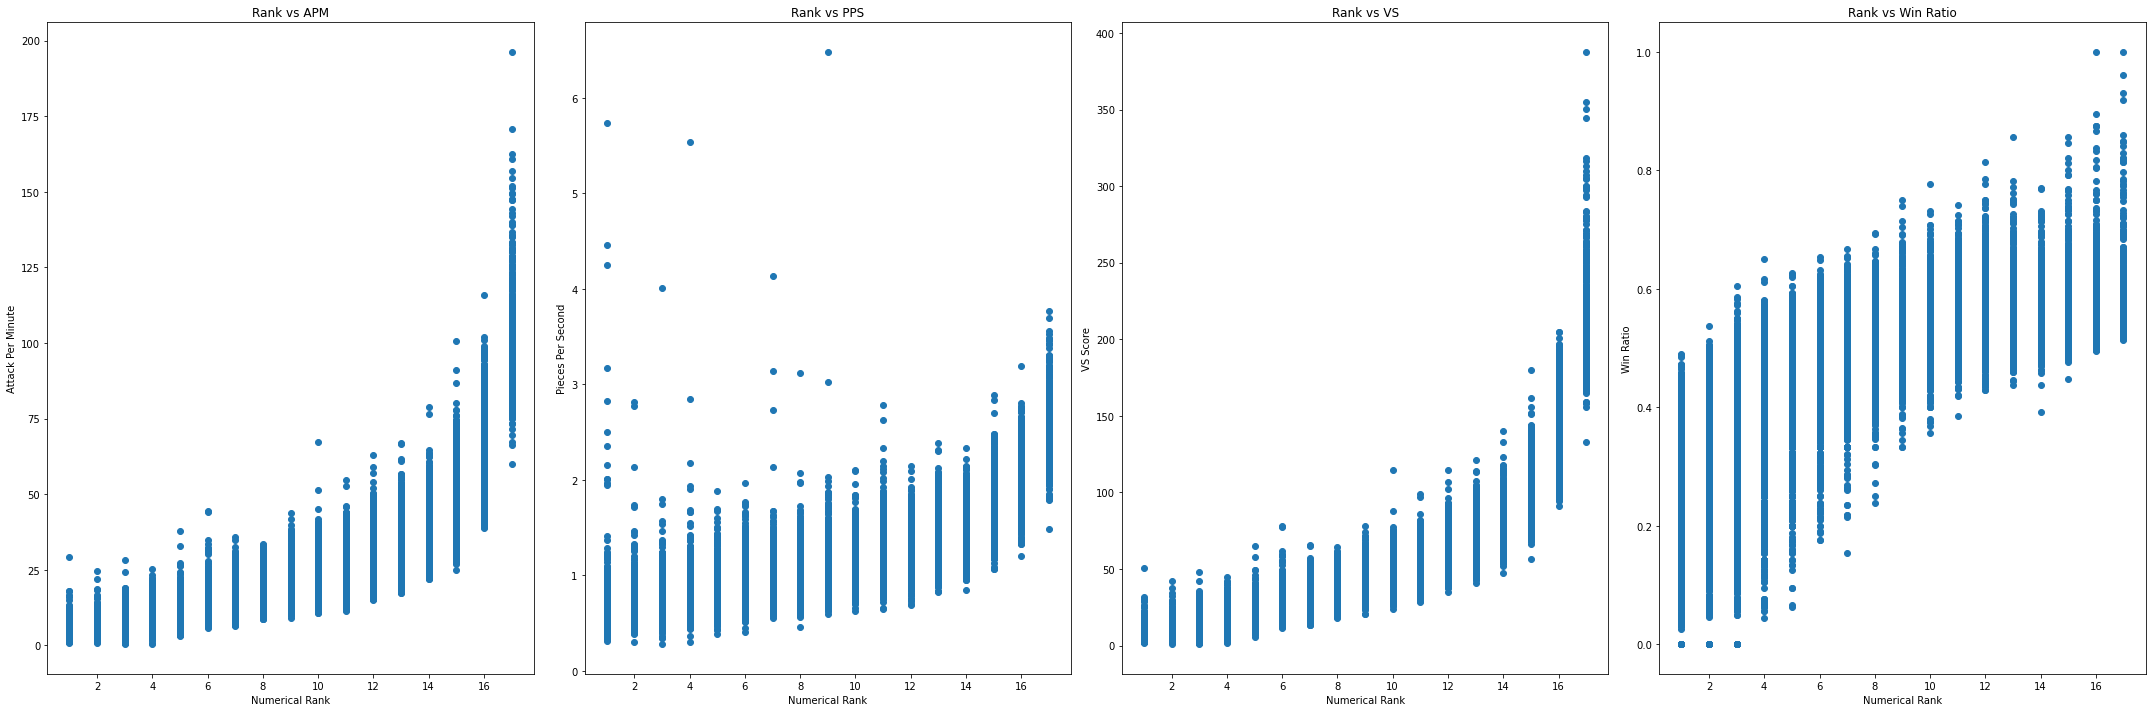

In [17]:
fig, ax = plt.subplots(figsize=(30,10), nrows = 1, ncols = 4)
ax[0].scatter(w_df.rank_num, w_df.apm)
ax[0].set_xlabel("Numerical Rank")
ax[0].set_ylabel("Attack Per Minute")
ax[0].set_title("Rank vs APM")

ax[1].scatter(w_df.rank_num, w_df.pps)
ax[1].set_xlabel("Numerical Rank")
ax[1].set_ylabel("Pieces Per Second")
ax[1].set_title("Rank vs PPS")

ax[2].scatter(w_df.rank_num, w_df.vs)
ax[2].set_xlabel("Numerical Rank")
ax[2].set_ylabel("VS Score")
ax[2].set_title("Rank vs VS")

ax[3].scatter(w_df.rank_num, w_df.winratio)
ax[3].set_xlabel("Numerical Rank")
ax[3].set_ylabel("Win Ratio")
ax[3].set_title("Rank vs Win Ratio")

plt.tight_layout()

We can see servere outliers in the above 5 pps yet d-tier range

In [18]:
w_df[w_df.pps > 5]

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio,rank_num
7958,189646.0,41,5,2470.142562,920.092147,85.012415,c,8.00,5.54,16.40,0.121951,4
32686,353005.0,179,80,587.855250,518.441356,80.532216,d,7.71,5.74,17.26,0.446927,1
34711,307512.5,106,49,11450.461866,1455.665832,80.301341,a-,13.63,6.48,25.89,0.462264,9


Remove the pps outliers

In [19]:
w_df = w_df[w_df.pps < 5]

Remove data entries whose pps are outside of 3 standard deviations to reduce data noise

In [74]:
# Outlier Removal
def outlier_removal(df, variable):
    upper_limit = df[variable].mean() + 3 * df[variable].std()
    lower_limit = df[variable].mean() - 3 * df[variable].std()
    return upper_limit, lower_limit

def pps_outlier_removal(df):
    for i in range(1, 18):    
        upper_limit, lower_limit = outlier_removal(df[df['rank_num'] == i], "pps")
        print(f"{i} Upper limit: ", upper_limit)
        print(f"{i} Lower Limit: ",lower_limit)
        df = df.drop(df[(df['rank_num'] == i) & ((df['pps'] < lower_limit) | (df['pps'] > upper_limit))].index)
    return df




In [ ]:
w_df = pps_outlier_removal(w_df)


Text(0.5, 1.0, 'Rank vs PPS')

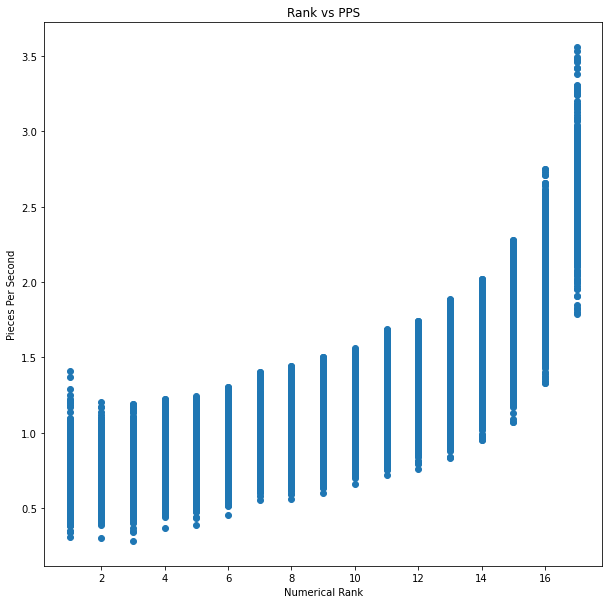

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(w_df.rank_num, w_df.pps)
ax.set_xlabel("Numerical Rank")
ax.set_ylabel("Pieces Per Second")
ax.set_title("Rank vs PPS")

In [188]:
def gen_x_y(df, y_feat):
    df_x = df.loc[:, ['apm', 'pps', 'vs', 'winratio']]
    df_y = df.loc[:, y_feat]
    return df_x, df_y

def train_val_test_split(df_x, df_y, train_size, val_size, random_state):
    X_train, X_split, y_train, y_split = train_test_split(df_x, df_y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_split, y_split, train_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [22]:
df_x = w_df.loc[:,['apm', 'pps', 'vs', 'winratio']]
df_x

,apm,pps,vs,winratio
0,11.05,0.82,22.00,0.458150
1,14.49,0.92,31.46,0.508902
2,21.04,0.80,38.79,0.571429
3,25.38,0.90,47.93,0.636364
4,7.34,0.64,14.50,0.485075
...,...,...,...,...
44105,5.99,0.56,10.93,0.230769
44106,11.82,0.82,23.60,0.542484
44107,46.03,1.44,93.12,0.530075
44108,19.64,1.13,43.84,0.519481


In [23]:
df_y = w_df['rank_num']
df_y

0         5
1         8
2         7
3         8
4         3
         ..
44105     1
44106     6
44107    14
44108    12
44109     6
Name: rank_num, Length: 43717, dtype: int64

Split the data into train and test sets

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_split, y_train, y_split = train_test_split(df_x, df_y, train_size=0.7, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_split, y_split, train_size=0.5, random_state=1)

In [25]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((30601, 4), (6558, 4), (6558, 4), (30601,), (6558,), (6558,))

Use the data to train 3 different classification models and see how they perform

In [35]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):

  np.random.seed(42)

  model_scores = {}

  for name, model in models.items():

    model.fit(X_train, y_train)
    model_scores[name] = model.score(X_test, y_test)

  return model_scores

In [74]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_val, y_train=y_train, y_test=y_val)
model_scores

c:\Users\Kang\.conda\envs\newtf\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.265934736200061,
 'KNN': 0.4072888075632815,
 'Random Forest': 0.44037816407441294}

<AxesSubplot:>

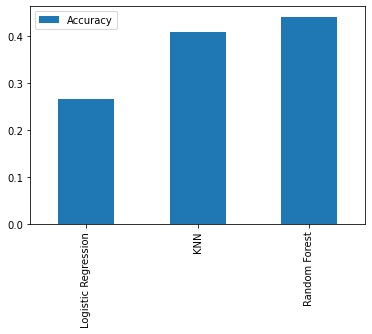

In [75]:
scores_df = pd.DataFrame(model_scores, index=["Accuracy"])
scores_df.T.plot.bar()

As you can see, it's not doing too well as the highest accuracy is only 43%. I try to tune some hyperparameters to see if there is any change even though I don't expect much.

In [76]:
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

# Tune RFC with RandomizedSearchCV

np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)

rs_rf.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [77]:
rs_rf.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [78]:
rs_rf.score(X_test, y_test)

0.47156578746760175

In [82]:
model = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=18, n_estimators=910)
model.fit(X_train, y_train)
y_preds = model.predict(X_val)

In [84]:
model.score(X_train, y_train)

0.5752842765651549

In [83]:
compare = pd.DataFrame([y_preds, y_test], index=["Predicted", "Actual"]).T
compare[compare.Predicted != compare.Actual]

,Predicted,Actual
0,17.0,7.0
1,16.0,11.0
2,2.0,3.0
3,13.0,12.0
4,3.0,8.0
...,...,...
6554,8.0,7.0
6555,4.0,17.0
6556,6.0,14.0
6557,4.0,15.0


# AdaBoost & Gradient Boost (XGBoost):
See if these ensemble boosting models can perform better than a Random Forest

In [27]:
ada = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=1,
    random_state=42
)
ada.fit(X_train, y_train)
ada.score(X_train, y_train)

0.20182346982124766

In [28]:
ada.score(X_val, y_val)

0.1956389143031412

With nearly default paramaters, AdaBoost is not doing well and I doubt there will be any significant improvement even with the "most optimal" settings.

In [86]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

c:\Users\Kang\.conda\envs\newtf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:14:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7445758724349758

In [87]:
xgb.score(X_val, y_val)

0.45288197621225984

XGBoost has much better train accuracy but simillar test accuracy to the Random Forest Classifier; could be a case of slight overfitting, but as a whole our current theoretical limit for model accuracy seems to be just around 47% using the Random Forest.

In the end, it didn't improve too much. The model couldn't predict the specific ranks correctly most of the time due to many categories to predict as well as rather little distinction between some of the categories. For example, A-, A, and A+ are technically all pretty similar and belong to the same class. By this logic, let's generalize the ranks and merge some of them together. With this, I shrunk the number of categories from 17 to 8, halving the amount and most likely going to provide a significant increase in prediction accuracy.

## Classification: Letter Rank (Combined Ranks)
---

In [41]:
ranks_grouped = {'d': 1, 'd+': 1, 'c-': 2, 'c': 2, 'c+': 2, 'b-': 3, 'b': 3, 'b+': 3, 'a-': 4, 'a':4, 'a+': 4, 's-': 5, 's': 5, 's+': 5, 'ss': 6, 'u': 7, 'x': 8}
g_df = process_data(df, ranks_grouped)
g_df = pps_outlier_removal(g_df)
g_df

1 Upper limit:  1.4345578662195262
1 Lower Limit:  -0.06935189066497849
2 Upper limit:  1.2688814913785595
2 Lower Limit:  0.2737354559617208
3 Upper limit:  1.4035166386403328
3 Lower Limit:  0.45569182456926816
4 Upper limit:  1.6447677222689912
4 Lower Limit:  0.5746260448997078
5 Upper limit:  1.9471987698554296
5 Lower Limit:  0.7472568872738485
6 Upper limit:  2.304342069986593
6 Lower Limit:  1.0456692807512122
7 Upper limit:  2.7588952084129676
7 Lower Limit:  1.2474103788162259
8 Upper limit:  3.6049717800400503
8 Lower Limit:  1.5595117364434667
9 Upper limit:  nan
9 Lower Limit:  nan
10 Upper limit:  nan
10 Lower Limit:  nan
11 Upper limit:  nan
11 Lower Limit:  nan
12 Upper limit:  nan
12 Lower Limit:  nan
13 Upper limit:  nan
13 Lower Limit:  nan
14 Upper limit:  nan
14 Lower Limit:  nan
15 Upper limit:  nan
15 Lower Limit:  nan
16 Upper limit:  nan
16 Lower Limit:  nan
17 Upper limit:  nan
17 Lower Limit:  nan


,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio,rank_num
0,391249.0,227,104,4015.128012,1065.996198,69.323796,c+,11.05,0.82,22.00,0.458150,2
4,262688.0,134,65,1428.925498,764.088339,90.512336,c-,7.34,0.64,14.50,0.485075,2
7,588537.0,228,117,10440.641981,1412.846739,64.876874,a-,20.32,0.90,39.40,0.513158,4
8,56063.0,15,8,16217.766076,1662.361665,93.432037,a+,17.39,1.11,41.48,0.533333,4
9,158578.5,58,30,20352.402779,1886.842267,83.777629,s+,45.07,1.40,84.79,0.517241,5
...,...,...,...,...,...,...,...,...,...,...,...,...
44103,1229218.5,332,163,11533.416301,1459.397390,73.834580,a-,13.90,1.01,32.44,0.490964,4
44104,1593835.5,243,135,19479.001447,1830.349005,67.896789,s,37.87,1.15,82.51,0.555556,5
44105,132009.0,39,9,458.952819,455.446185,87.159710,d,5.99,0.56,10.93,0.230769,1
44107,1830967.0,532,282,21129.588330,1944.330700,60.642321,s+,46.03,1.44,93.12,0.530075,5


In [44]:
df_x, df_y = gen_x_y(g_df, 'rank_num')
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_x, df_y, 0.7, 0.5, 1)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((23094, 4), (4949, 4), (4949, 4), (23094,), (4949,), (4949,))

In [45]:
fit_and_score(models=models, X_train=X_train, X_test=X_val, y_train=y_train, y_test=y_val)


c:\Users\Kang\.conda\envs\newtf\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.7256011315417256,
 'KNN': 0.8221863002626794,
 'Random Forest': 0.8355223277429784}

In [46]:
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

#Tune RFC with RandomizedSearchCV

np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)

rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [47]:
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [48]:
model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=14, n_estimators=510)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [49]:
model.score(X_train, y_train)

0.9269507231315494

In [50]:
model.score(X_val, y_val)

0.8436047686401293

### Test XGBoost:

In [51]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

c:\Users\Kang\.conda\envs\newtf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9342253399151295

In [52]:
xgb.score(X_val, y_val)

0.841180036370984

In [ ]:
rf_grid = {
    "n_estimators": np.arange(50,500,50),
    "max_depth": [None, 3, 5, 10],
    "min_child_weight": np.arange(0, 10, 2),
    "learning_rate": [0.01, 0.1, 0.5]
}

xgb_rf = RandomizedSearchCV(xgboost.XGBClassifier(objective="multi:softmax", num_classes=8), param_distributions=rf_grid, cv=5, n_iter=20, verbose=2)

xgb_rf.fit(X_train, y_train)

In [57]:
xgb_rf.best_params_

{'n_estimators': 50,
 'min_child_weight': 6,
 'max_depth': 3,
 'learning_rate': 0.5}

In [58]:
xgb = xgboost.XGBClassifier(n_estimators=50, min_child_weight=6, max_depth=3, learning_rate=0.5, verbose=1)
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

c:\Users\Kang\.conda\envs\newtf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:57:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8680176669264744

In [59]:
xgb.score(X_val, y_val)

0.8434027076177005

Random Forest still gives better results.

---

I do everything like before to pre-process the data

In [ ]:
ranks_grouped = {'d': 1, 'd+': 1, 'c-': 2, 'c': 2, 'c+': 2, 'b-': 3, 'b': 3, 'b+': 3, 'a-': 4, 'a':4, 'a+': 4, 's-': 5, 's': 5, 's+': 5, 'ss': 6, 'u': 7, 'x': 8}
df['rank_grouped'] = df['rank'].map(ranks_grouped)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,_id,username,role,verified,country,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,decaying,supporter,rank_num,rank_grouped
0,5e697bbf77aba60f95fb38da,firestorm,user,True,US,420,379,24984.207686,3455.023332,99.691619,x,161.54,3.70,327.45,False,NaN,17,8
1,5e844b0868270e617d52c990,czsmall0402,user,False,None,243,220,24979.819835,3377.895770,83.678807,x,146.59,3.08,315.33,False,True,17,8
2,5f5dbcc4454e942b4fdfc5fa,vincehd_,user,True,PH,168,155,24979.362628,3361.819973,67.266272,x,147.86,3.41,321.52,False,True,17,8
3,5e7cd9b6552a596c95f3c0a0,jason0107,user,False,TW,209,179,24969.901499,3263.479440,68.653978,x,101.06,3.62,225.07,False,NaN,17,8
4,6005c355413441e94a56c91f,seunghun1004,user,False,KR,133,121,24969.647383,3262.660942,71.211274,x,119.61,3.25,274.29,False,NaN,17,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,5fc40de613e8c021da3a03fe,blindsixx,user,False,DO,101,13,234.876448,278.324268,75.153043,d,3.31,0.16,7.32,True,NaN,1,1
15548,5fe95de14529400ba470617e,shootinstar,user,False,US,49,4,232.492803,271.673481,93.279333,d,2.65,0.51,6.33,True,NaN,1,1
15549,5fdbade9e3ea3a3755f37ebf,sis25,user,False,AR,291,72,217.319911,257.507800,78.842107,d,6.57,0.87,11.89,True,NaN,1,1
15550,6013a88bf5c57ce9662953b5,ramsesin,user,False,MX,89,16,212.656891,251.015453,70.827004,d,4.11,0.48,7.85,True,NaN,1,1


In [ ]:
df_shuffled = shuffle(df, random_state=1)
df_shuffled = df_shuffled.reset_index(drop=True)

In [ ]:
main_df = df_shuffled.loc[:,"gamesplayed":"vs"]
main_df["rank_grouped"] = df_shuffled["rank_grouped"]
main_df

,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,rank_grouped
0,278,148,7822.799453,1294.039806,74.644066,b,16.17,0.96,30.43,3
1,21,10,5471.910625,1164.212459,86.023400,b-,16.25,1.14,30.18,3
2,75,23,834.083974,618.085745,63.332430,d+,4.78,0.50,10.33,1
3,27,15,4191.483025,1077.551627,83.077035,c+,11.00,0.83,21.48,2
4,46,25,13898.670890,1558.948008,67.671488,a,17.98,1.15,41.61,4
...,...,...,...,...,...,...,...,...,...,...
15545,579,302,22737.456726,2104.147175,61.087927,ss,38.33,1.49,95.49,6
15546,316,156,15270.018557,1618.018270,61.807109,a+,25.70,1.18,56.42,4
15547,99,47,4199.946801,1080.793994,63.935905,c+,10.47,0.89,24.52,2
15548,343,210,24237.777102,2405.982686,62.091603,u,73.59,2.29,164.83,7


In [ ]:
df_x = main_df.loc[:,['apm', 'pps', 'vs']]
df_x

,apm,pps,vs
0,16.17,0.96,30.43
1,16.25,1.14,30.18
2,4.78,0.50,10.33
3,11.00,0.83,21.48
4,17.98,1.15,41.61
...,...,...,...
15545,38.33,1.49,95.49
15546,25.70,1.18,56.42
15547,10.47,0.89,24.52
15548,73.59,2.29,164.83


In [ ]:
df_y = main_df.loc[:,"rank_grouped"]
df_y

0        3
1        3
2        1
3        2
4        4
        ..
15545    6
15546    4
15547    2
15548    7
15549    2
Name: rank_grouped, Length: 15550, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.7, random_state=1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10885, 3), (4665, 3), (10885,), (4665,))

In [ ]:
fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'KNN': 0.7466237942122187,
 'Logistic Regression': 0.5952840300107182,
 'Random Forest': 0.7466237942122187}

A significant increase in prediction accuracy from 43% up to 74%. I yet again tune hyperparameters to see if I can get slightly better results.

In [ ]:
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

#Tune RFC with RandomizedSearchCV

np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)

rs_rf.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rs_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 510}

These parameters are what I got, and they may change as I use RandomizedSearchCV which does not check all possibilities. If I wanted to get the best possible model, GridSearchCV should be used.

In [ ]:
model = RandomForestClassifier(max_depth=None, min_samples_leaf=5, min_samples_split=12, n_estimators=310)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.7631296891747053

We got the final predicted accuracy of 76%

I wanted to see the deviation in the predicted values versus the actual values in terms of the prediction frequency. From the graph below, the predictions are on par with the actual values.

(array([ 236.,  818., 1108.,    0., 1116.,  863.,    0.,  286.,  196.,
          42.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

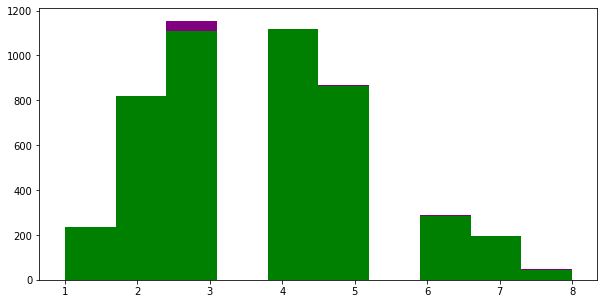

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(y_preds, color="purple")
plt.hist(y_test, color="green")

Just out of curiosity sake, I look to see some of the wrong predictions and see their differences. 

In [ ]:
compare = pd.DataFrame([y_preds, y_test], index=["Predicted", "Actual"]).T
compare

,Predicted,Actual
0,2,2
1,3,3
2,7,7
3,1,1
4,2,2
...,...,...
4660,7,7
4661,5,5
4662,2,2
4663,5,5


In [ ]:
compare[compare.Predicted != compare.Actual]

,Predicted,Actual
5,3,2
7,2,3
24,4,3
28,4,5
30,3,4
...,...,...
4631,3,2
4635,4,3
4641,2,3
4646,5,6


As I expected, the wrong predictions are only off by 1 rank. 

### Afterthought

There was not too much data to begin with as Tetr.io is a rather small platform, so for what it is, the model did pretty decently. From the diagrams above, we could see that there wasn't a clear distinction between the ranks and there was a lot of overlap which directly affects prediction accuracy. I don't think the model could have done much better at its current state as the players in the data do not progress linearly in ranks aside their other statistics. Overall, 76% accuracy is pretty good considering all the problems that exist in this data. 

# Regression on Tetra Rating (then classification on Rank)
---

In [120]:
r_df = process_data(df)
r_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio
0,391249.0,227,104,4015.128012,1065.996198,69.323796,c+,11.05,0.82,22.00,0.458150
1,1428871.0,674,343,9840.002815,1386.593515,98.724149,b+,14.49,0.92,31.46,0.508902
2,259914.0,98,56,6331.781342,1216.882010,61.498757,b,21.04,0.80,38.79,0.571429
3,547439.0,77,49,9171.385908,1356.913698,90.179085,b+,25.38,0.90,47.93,0.636364
4,262688.0,134,65,1428.925498,764.088339,90.512336,c-,7.34,0.64,14.50,0.485075
...,...,...,...,...,...,...,...,...,...,...,...
44105,132009.0,39,9,458.952819,455.446185,87.159710,d,5.99,0.56,10.93,0.230769
44106,332077.5,153,83,5304.005526,1156.013116,66.211362,b-,11.82,0.82,23.60,0.542484
44107,1830967.0,532,282,21129.588330,1944.330700,60.642321,s+,46.03,1.44,93.12,0.530075
44108,316694.0,154,80,17017.556216,1698.824552,76.877914,s-,19.64,1.13,43.84,0.519481


Text(0.5, 1.0, 'Rating vs Win Ratio')

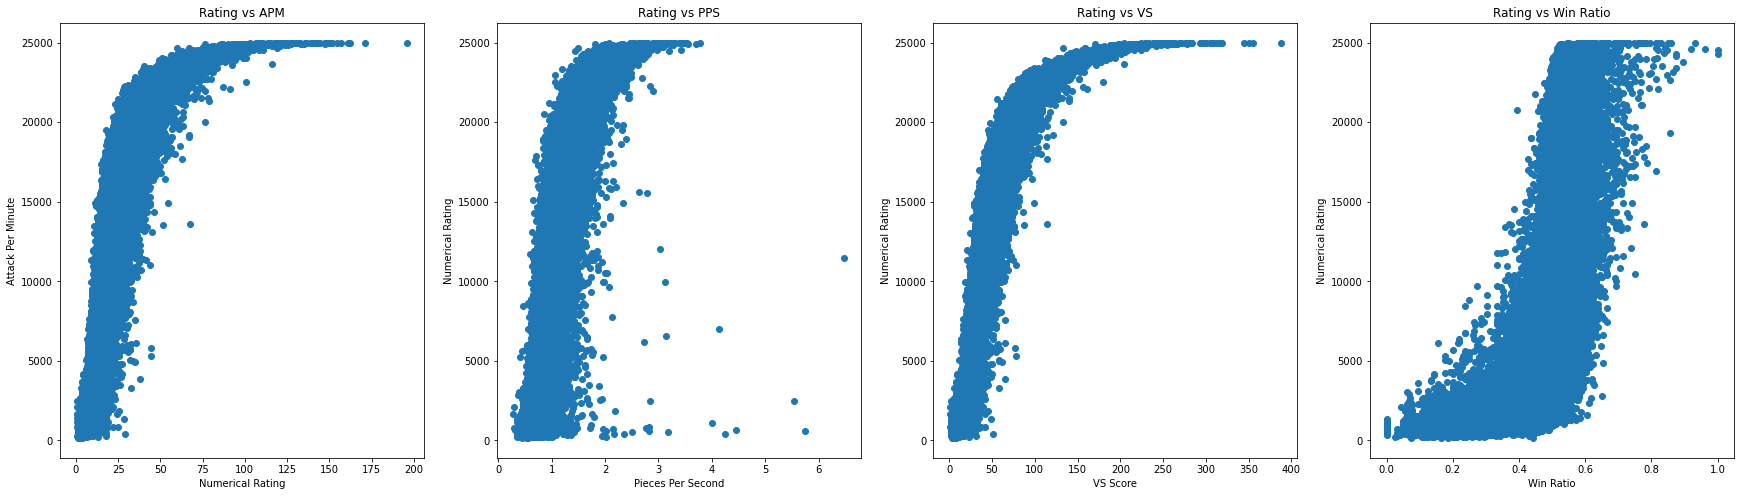

In [121]:
fig, ax = plt.subplots(figsize=(30,8), nrows = 1, ncols = 4)
ax[0].scatter(r_df.apm, r_df.rating)
ax[0].set_xlabel("Numerical Rating")
ax[0].set_ylabel("Attack Per Minute")
ax[0].set_title("Rating vs APM")

ax[1].scatter(r_df.pps, r_df.rating)
ax[1].set_ylabel("Numerical Rating")
ax[1].set_xlabel("Pieces Per Second")
ax[1].set_title("Rating vs PPS")

ax[2].scatter(r_df.vs, r_df.rating)
ax[2].set_ylabel("Numerical Rating")
ax[2].set_xlabel("VS Score")
ax[2].set_title("Rating vs VS")

ax[3].scatter(r_df.winratio, r_df.rating)
ax[3].set_ylabel("Numerical Rating")
ax[3].set_xlabel("Win Ratio")
ax[3].set_title("Rating vs Win Ratio")

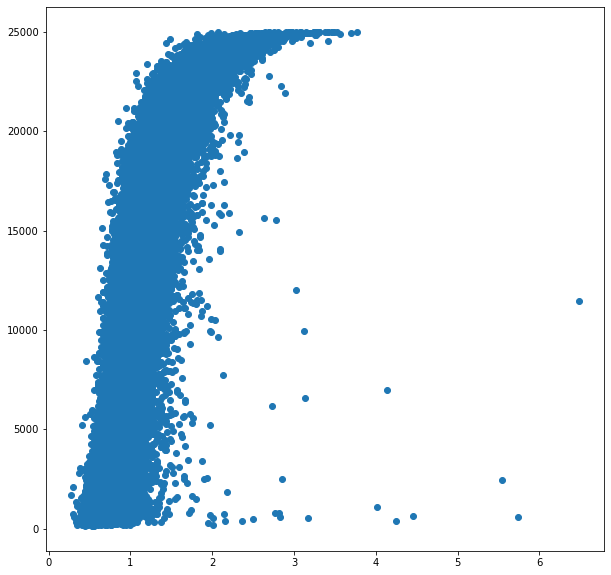

In [122]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(r_df.pps, r_df.rating)

Removing the clear outliers in the dataset.

In [123]:
r_df.drop(r_df[(r_df.rating < 5000) & (r_df.pps > 2)].index, inplace=True)
r_df.drop(r_df[(r_df.rating < 10000) & (r_df.pps > 2.5)].index, inplace=True)
r_df.drop(r_df[(r_df.rating < 15000) & (r_df.pps > 2.5)].index, inplace=True)

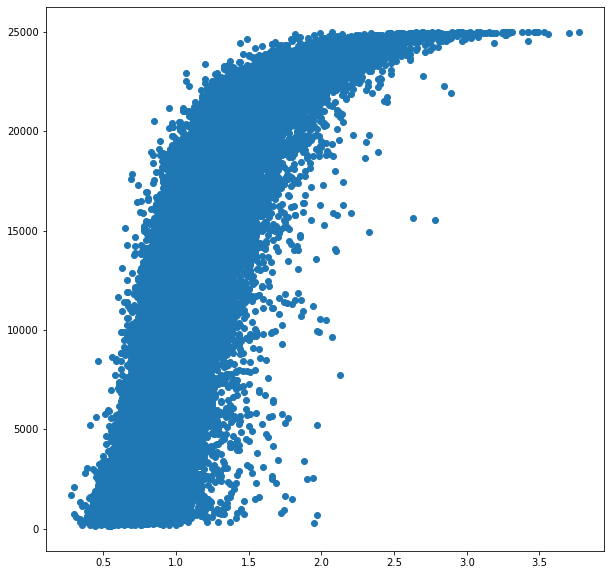

In [124]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(r_df.pps, r_df.rating)

In [125]:
r_df_x, r_df_y = gen_x_y(r_df, 'rating')
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(r_df_x, r_df_y, 0.7, 0.5, 1)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((30860, 4), (6613, 4), (6614, 4), (30860,), (6613,), (6614,))

In [126]:
models = {"Linear Regression": LinearRegression(),
          "KNN": KNeighborsRegressor(),
          "Random Forest": RandomForestRegressor()}

fit_and_score(models=models, X_train=X_train, X_test=X_val, y_train=y_train, y_test=y_val)

{'Linear Regression': 0.8061177906497125,
 'KNN': 0.9538091157733362,
 'Random Forest': 0.9595646742395936}

In [134]:
rf_grid = {"n_estimators": np.arange(50,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

#Tune RFC with RandomizedSearchCV

np.random.seed(42)

r_rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=2)

r_rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=None, min_samples_leaf=11, min_samples_split=2, n_estimators=300; total time=  19.4s
[CV] END max_depth=None, min_samples_leaf=11, min_samples_split=2, n_estimators=300; total time=  19.6s
[CV] END max_depth=None, min_samples_leaf=11, min_samples_split=2, n_estimators=300; total time=  19.9s
[CV] END max_depth=None, min_samples_leaf=11, min_samples_split=2, n_estimators=300; total time=  19.1s
[CV] END max_depth=None, min_samples_leaf=11, min_samples_split=2, n_estimators=300; total time=  19.0s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  41.2s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  41.0s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  40.9s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  41.0s
[CV] END m

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])},
                   verbose=2)

In [135]:
r_rs_rf.best_params_

{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [136]:
r_rf = RandomForestRegressor(n_estimators=700, min_samples_leaf=10, min_samples_split=3, max_depth=10)
r_rf.fit(X_train, y_train)
r_rf.score(X_val, y_val)

0.9613170228598346

In [140]:
r_rf.score(X_train, y_train)

0.9667411020764243

In [137]:
r_rf_preds = r_rf.predict(X_val)
r_rf_mse = mean_squared_error(y_val, r_rf_preds)
print(f"RMSE: {math.sqrt(r_rf_mse)}")

RMSE: 1427.621407086299


### Polynomial Regression
By adding polynomial features, we can allow the Linear Regressor to predict polynomial shapes.

In [127]:
for i in range(2, 11):
    poly_feat = PolynomialFeatures(degree=i)
    X_train_poly = poly_feat.fit_transform(X_train)
    X_val_poly = poly_feat.fit_transform(X_val)
    print(f"i = {i}")
    print(fit_and_score(models={"LR": LinearRegression()}, X_train=X_train_poly, X_test=X_val_poly, y_train=y_train, y_test=y_val))

i = 2
{'LR': 0.9338133607809778}
i = 3
{'LR': 0.9549274673135146}
i = 4
{'LR': 0.9591958166996384}
i = 5
{'LR': 0.9605868237027786}
i = 6
{'LR': 0.9566680720314088}
i = 7
{'LR': 0.7107453937726729}
i = 8
{'LR': -8.143178803961275}
i = 9
{'LR': -1.0529736726561953}
i = 10
{'LR': -144.39665747896106}


The highest accuracy is with degree of 5 with 4 as a close second, but this may just be for this random split of the dataset. If I wanted to be very precise, I would use cross-validation, but since intuitively it should land at one of these 2 for the most part, I will choose to use 5.

In [128]:
poly_feat = PolynomialFeatures(degree=5)
X_train_poly = poly_feat.fit_transform(X_train)
X_val_poly = poly_feat.fit_transform(X_val)
X_test_poly = poly_feat.fit_transform(X_test)
X_train_poly.shape, X_val_poly.shape, X_test_poly.shape

((30860, 126), (6613, 126), (6614, 126))

In [129]:
fit_and_score(models={"LR": LinearRegression()}, X_train=X_train_poly, X_test=X_val_poly, y_train=y_train, y_test=y_val)

{'LR': 0.9605868237027786}

In [130]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)
lr_y_preds = lr.predict(X_val_poly)
mse = mean_squared_error(y_val, lr_y_preds)
print(f"RMSE: {math.sqrt(mse)}")

RMSE: 1441.0326602170883


### XGBoost

In [139]:
rg_xgb = xgboost.XGBRegressor()
rg_xgb.fit(X_train, y_train)
rg_xgb.score(X_val, y_val)

0.9603100963914303

In [141]:
rg_xgb.score(X_train, y_train)

0.971935771584937

In [142]:
rg_grid = {
    "n_estimators": np.arange(50,500,50),
    "max_depth": [None, 3, 5, 10],
    "min_child_weight": np.arange(0, 10, 2),
    "learning_rate": [0.01, 0.1, 0.5]
}

xgb_rg = RandomizedSearchCV(xgboost.XGBRegressor(), param_distributions=rg_grid, cv=3, n_iter=30, verbose=2)

xgb_rg.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=450; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=450; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=450; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=None, min_child_weight=8, n_estimators=200; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=None, min_child_weight=8, n_estimators=200; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=None, min_child_weight=8, n_estimators=200; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=2, n_estimators=150; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=2, n_estimators=150; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=10, min_child_weight=2, n_estimators=150; total time=   4.2s
[CV] END learning_rate=0.5, max_dept

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None,
                                       

In [143]:
xgb_rf.best_params_

{'n_estimators': 50,
 'min_child_weight': 6,
 'max_depth': 3,
 'learning_rate': 0.5}

In [144]:
rg_xgb = xgboost.XGBRegressor(n_estimators=50, min_child_weight=6, max_depth=3, learning_rate=0.5)
rg_xgb.fit(X_train, y_train)
rg_xgb.score(X_val, y_val)

0.960756977799105

In [145]:
xgb_y_preds = rg_xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_y_preds)
print(f"RMSE: {math.sqrt(mse)}")

RMSE: 1437.9186911464938


As a next step, I could use a Voting Regressor to combine all these models for a stronger one, but I believe this might be a little overkill for this use case.


The best performance is from the Random Forest Regressor with an RMSE of 1427, meaning the prediction is on average, 1427 rating off of the actual rating of the player.  
Using [this site](https://tetrio.team2xh.net/?t=ranks) we can see that being 1400 off is around or more than a whole rank difference in terms of rating.  
As all the models I've tried are performing similarly, it is safe to say that due to the natural diversity and unstructuredness of a player's statistics can translate to rank.  
Keep in mind that I am not able to account for those who higher or lower than what they *should* be rated at, which will definitely also cause inconsistencies.


## Rating to Rank Classifier
To predict letter rank using a player's rating, which can be combined with the previous model to perform the same task as the first section and predict a player's letter rank.

In [146]:
w_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio,rank_num
0,391249.0,227,104,4015.128012,1065.996198,69.323796,c+,11.05,0.82,22.00,0.458150,5
1,1428871.0,674,343,9840.002815,1386.593515,98.724149,b+,14.49,0.92,31.46,0.508902,8
2,259914.0,98,56,6331.781342,1216.882010,61.498757,b,21.04,0.80,38.79,0.571429,7
3,547439.0,77,49,9171.385908,1356.913698,90.179085,b+,25.38,0.90,47.93,0.636364,8
4,262688.0,134,65,1428.925498,764.088339,90.512336,c-,7.34,0.64,14.50,0.485075,3
...,...,...,...,...,...,...,...,...,...,...,...,...
44105,132009.0,39,9,458.952819,455.446185,87.159710,d,5.99,0.56,10.93,0.230769,1
44106,332077.5,153,83,5304.005526,1156.013116,66.211362,b-,11.82,0.82,23.60,0.542484,6
44107,1830967.0,532,282,21129.588330,1944.330700,60.642321,s+,46.03,1.44,93.12,0.530075,14
44108,316694.0,154,80,17017.556216,1698.824552,76.877914,s-,19.64,1.13,43.84,0.519481,12


In [147]:
rr_df_x = w_df.rating
rr_df_y = w_df.rank_num
rr_df_x.shape, rr_df_y.shape

((43520,), (43520,))

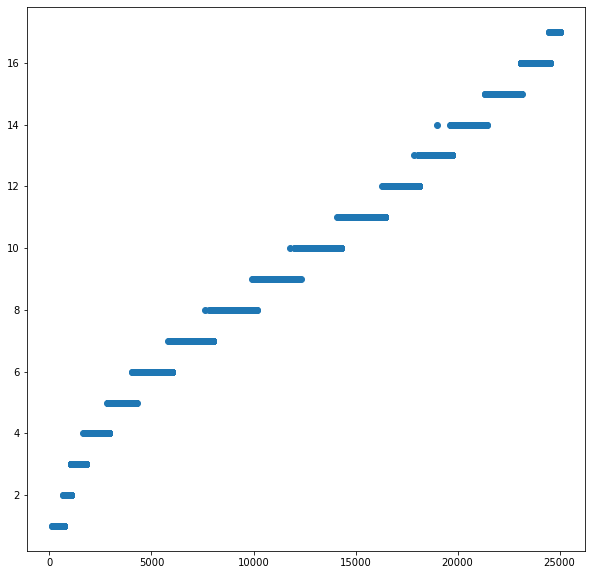

In [148]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(rr_df_x, rr_df_y)

Judging from the above graph, a simpler model may actually be better.

In [153]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(rr_df_x, rr_df_y, 0.7, 0.5, 1)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((30463,), (6528,), (6529,), (30463,), (6528,), (6529,))

In [159]:
X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
X_val = X_val.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [160]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}
fit_and_score(models=models, X_train=X_train, X_test=X_val, y_train=y_train, y_test=y_val)


c:\Users\Kang\.conda\envs\newtf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\Kang\.conda\envs\newtf\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-35-110e88543861>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


{'Logistic Regression': 0.0586703431372549,
 'KNN': 0.9908088235294118,
 'Random Forest': 0.9868259803921569}

In [161]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_val, y_val)

c:\Users\Kang\.conda\envs\newtf\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9908088235294118

In [162]:
knn.score(X_train, y_train)

0.9910383087680137

Since it already has amazing accuracy, I will just use it.

### Combining the models

In [173]:
w_df

,xp,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,winratio,rank_num
0,391249.0,227,104,4015.128012,1065.996198,69.323796,c+,11.05,0.82,22.00,0.458150,5
1,1428871.0,674,343,9840.002815,1386.593515,98.724149,b+,14.49,0.92,31.46,0.508902,8
2,259914.0,98,56,6331.781342,1216.882010,61.498757,b,21.04,0.80,38.79,0.571429,7
3,547439.0,77,49,9171.385908,1356.913698,90.179085,b+,25.38,0.90,47.93,0.636364,8
4,262688.0,134,65,1428.925498,764.088339,90.512336,c-,7.34,0.64,14.50,0.485075,3
...,...,...,...,...,...,...,...,...,...,...,...,...
44105,132009.0,39,9,458.952819,455.446185,87.159710,d,5.99,0.56,10.93,0.230769,1
44106,332077.5,153,83,5304.005526,1156.013116,66.211362,b-,11.82,0.82,23.60,0.542484,6
44107,1830967.0,532,282,21129.588330,1944.330700,60.642321,s+,46.03,1.44,93.12,0.530075,14
44108,316694.0,154,80,17017.556216,1698.824552,76.877914,s-,19.64,1.13,43.84,0.519481,12


In [189]:
f_df_x, f_df_y = gen_x_y(w_df, ["rating", "rank_num"])

In [190]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(f_df_x, f_df_y, 0.7, 0.5, 1)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((30463, 4), (6528, 4), (6529, 4), (30463, 2), (6528, 2), (6529, 2))

In [187]:
r_y_preds = r_rf.predict(X_train)
r_y_preds = r_y_preds.reshape(-1, 1)
r_y_preds

array([[ 6351.19768599],
       [ 4340.37974423],
       [ 1402.82558974],
       ...,
       [21430.01824321],
       [21469.63306484],
       [15758.18423649]])

In [191]:
y_train.loc[:, "rating"]

27951     5099.876158
10868     4151.039371
8816       900.363533
6073     12365.831596
16715    19962.249119
             ...     
7929     17112.086966
32955     8878.623835
5269     22144.683834
12355    20890.728949
33450    13786.532694
Name: rating, Length: 30463, dtype: float64

In [ ]:
c_y_preds = knn.predict(r_y_preds)
c_y_preds

In [184]:
y_train = y_train.values.reshape(1, -1).flatten()

In [186]:
accuracy_score(y_train, c_y_preds)

0.49558480779962577